In [1]:
!pip install japanize_matplotlib
!pip install transformers
!pip install portalocker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=307b690fc3201c1d921ce7964776254da01d4e753847406510cb38b24f5e56cc
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:00


In [2]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext import datasets
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import string
import re
from typing import List, Union
from tqdm.notebook import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# GPUが利用可能かチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import pickle
# 読み込むpickleファイルのパス
folder_path = "drive/MyDrive/見原/Data/data_set.pkl"

# pickleファイルを読み込む
with open(folder_path, 'rb') as file:
    data_set = pickle.load(file)

# 読み込んだDataFrameの表示
display(data_set.head(1))

,Bug ID,Changed,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,...,TBF__fft_coefficient__attr_real__coeff_0,TBF__cwt_coefficients__coeff_0__w_10__widths_2 5 10 20,TBF__quantile__q_01,TBF__cwt_coefficients__coeff_0__w_5__widths_2 5 10 20,TBF__value_count__value_0,TBF__mean,TBF__quantile__q_02,TBF__count_below__t_0,TBF__range_count__max_1__min_1,TBF__value_count__value_1
Opened,,,,,,,,,,,,,,,,,,,,,
2012-06-26 09:27:15,835466,2013-07-04 02:47:20,David Naori,Alan Pevec,openstack-nova,CURRENTRELEASE,x86_64,Linux,high,1.0 (Essex),...,6.0,1.645634,6.0,2.327277,0.0,6.0,6.0,0.0,0.0,0.0


In [3]:
# def np_log(x):
#     return np.log(np.clip(x, 1e-10, None))
def np_log(x):
    x_nonzero = np.where(x == 0, 1e-10, x)
    return np.log(np.clip(x_nonzero, 1e-10, np.finfo(float).max))

In [4]:
df = pd.DataFrame()
df["TTR"] = data_set["TTR"]
df["Summary"] = data_set["Summary"]
df["log_TTR"] = np_log(df["TTR"])
df["label"] = df["log_TTR"].apply(lambda x: 1 if x > 0 else 0)

In [71]:
# # 回帰
# import torch
# import torch.nn as nn
# from transformers import BertTokenizer, BertModel

# # Bertモデルのロード
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# # カスタムの回帰モデルを定義
# class CustomRegressionModel(nn.Module):
#     def __init__(self, bert_model):
#         super(CustomRegressionModel, self).__init__()
#         self.bert = bert_model
#         self.regression_layer = nn.Linear(bert_model.config.hidden_size, 1)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids.to(device), attention_mask=attention_mask.to(device))
#         pooled_output = outputs.pooler_output
#         regression_output = self.regression_layer(pooled_output)
#         return regression_output

# # カスタムモデルを定義
# model = CustomRegressionModel(bert_model).to(device)

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

# 事前学習済みのBERTモデルとTokenizerをロード
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# # データをリスト形式に変換
# input_texts = df["Summary"].tolist()
# labels = df["label"].tolist()

# # データを訓練データとテストデータに分割
# input_texts_train, input_texts_test, labels_train, labels_test = train_test_split(
#     input_texts, labels, test_size=0.1, random_state=42
# )

# # 訓練データをトークン化してTensorに変換
# inputs_train = tokenizer(input_texts_train, padding=True, truncation=True, return_tensors="pt")
# input_ids_train = inputs_train["input_ids"].to(device)
# attention_mask_train = inputs_train["attention_mask"].to(device)
# labels_train = torch.tensor(labels_train, dtype=torch.float32).to(device)

# # テストデータをトークン化してTensorに変換
# inputs_test = tokenizer(input_texts_test, padding=True, truncation=True, return_tensors="pt")
# input_ids_test = inputs_test["input_ids"].to(device)
# attention_mask_test = inputs_test["attention_mask"].to(device)
# labels_test = torch.tensor(labels_test, dtype=torch.float32).to(device)

# # 損失関数を定義（MSEなど）
# loss_fn = nn.MSELoss()

# # 最適化手法を定義
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [6]:
from sklearn.model_selection import train_test_split
import torch

# 分類
input_texts = df["Summary"].tolist()
labels = df["label"].tolist()

# データを訓練データとテストデータに分割
input_texts_train, input_texts_test, labels_train, labels_test = train_test_split(
    input_texts, labels, test_size=0.1, random_state=42
)

# 訓練データをトークン化してTensorに変換
inputs_train = tokenizer(input_texts_train, padding=True, truncation=True, return_tensors="pt")
input_ids_train = inputs_train["input_ids"].to(device)
attention_mask_train = inputs_train["attention_mask"].to(device)
labels_train = torch.tensor(labels_train, dtype=torch.long).to(device)  # クラス分類の場合、ラベルをtorch.long型に変換する必要があります

# テストデータをトークン化してTensorに変換
inputs_test = tokenizer(input_texts_test, padding=True, truncation=True, return_tensors="pt")
input_ids_test = inputs_test["input_ids"].to(device)
attention_mask_test = inputs_test["attention_mask"].to(device)
labels_test = torch.tensor(labels_test, dtype=torch.long).to(device)  # クラス分類の場合、ラベルをtorch.long型に変換する必要があります

# # モデルに入力を与えて訓練データの予測を行う
# model.eval()
# with torch.no_grad():
#     outputs_train = model(input_ids_train, attention_mask=attention_mask_train)

# # 予測結果を取得（訓練データ）
# logits_train = outputs_train.logits
# predicted_labels_train = torch.argmax(logits_train, dim=1).cpu().numpy()

# # モデルに入力を与えてテストデータの予測を行う
# with torch.no_grad():
#     outputs_test = model(input_ids_test, attention_mask=attention_mask_test)

# # 予測結果を取得（テストデータ）
# logits_test = outputs_test.logits
# predicted_labels_test = torch.argmax(logits_test, dim=1).cpu().numpy()


In [19]:
from torch.utils.data import DataLoader, TensorDataset

# 訓練データをTensorDatasetにまとめる
train_dataset = TensorDataset(input_ids_train, attention_mask_train, labels_train)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, labels_test)

# バッチサイズを指定してDataLoaderを作成
batch_size = 128  # バッチサイズを適宜調整してください
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
accumulation_steps = 4
# 損失関数を定義（MSEなど）
loss_fn = nn.CrossEntropyLoss()

# 最適化手法を定義
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
# モデルの訓練
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        input_ids_batch, attention_mask_batch, labels_batch = batch

        # バッチごとに勾配を計算し、蓄積
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        loss = loss_fn(outputs.logits.squeeze(), labels_batch)
        loss.backward()

        # バッチごとに平均勾配を計算
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    # epochごとの平均ロスを出力
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1/3, Loss: 0.1738


Epoch 2/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.1670


Epoch 3/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.1590


In [20]:
model.eval()
predictions = []

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        input_ids_batch, attention_mask_batch, _ = batch  # テストデータなのでlabelsは不要

        # 予測を行い、結果をpredictionsに追加
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted_labels.cpu().t
                           olist())

# 予測結果のリストをNumPy配列に変換
predictions = np.array(predictions)
print(predictions)


[1 1 1 ... 1 1 1]


In [35]:
print(predictions[predictions == 0])

[]


In [31]:
from sklearn.metrics import roc_auc_score, roc_curve

# AUCを計算
auc = roc_auc_score(y_test, predictions)

print("AUC:", auc)


AUC: 0.5


In [74]:
# # Gradient Accumulationの設定
# accumulation_steps = 4

# # モデルの訓練
# num_epochs = 3
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0

#     # tqdmをtrain_loaderに適用する
#     for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
#         input_ids_batch, attention_mask_batch, labels_batch = batch

#         # バッチごとに勾配を計算し、蓄積
#         outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
#         loss = loss_fn(outputs.squeeze(), labels_batch)
#         loss = loss / accumulation_steps  # 勾配をaccumulation_stepsで割る
#         loss.backward()

#         # accumulation_steps回の勾配計算でパラメータを更新
#         if (step + 1) % accumulation_steps == 0:
#             optimizer.step()
#             optimizer.zero_grad()

#         total_loss += loss.item()

#     # epochごとの平均ロスを出力
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1/3, Loss: 0.0273


Epoch 2/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.0101


Epoch 3/3:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.0100


In [17]:
model.eval()
predictions = []

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        input_ids_batch, attention_mask_batch, _ = batch  # テストデータなのでlabelsは不要

        # 予測を行い、結果をpredictionsに追加
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions.extend(outputs.squeeze().cpu().tolist())

# 予測結果のリストをNumPy配列に変換
predictions = np.array(predictions)
print(predictions)


AttributeError: ignored

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['label']), df[['label']], test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17121, 3)
(1903, 3)
(17121, 1)
(1903, 1)


In [67]:
print(np_log(y_train.head(600)))

[[  5.91889385]
 [  7.86518795]
 [  7.20934026]
 [  7.18765716]
 [  7.18765716]
 [  6.02102335]
 [  7.18538702]
 [  7.17165682]
 [  7.17088848]
 [  7.17472431]
 [  5.62762111]
 [  7.17242458]
 [  7.83715965]
 [  7.83360022]
 [  7.83360022]
 [  7.86787149]
 [  7.16472038]
 [  7.86095636]
 [  7.16084591]
 [  5.57972983]
 [  7.16472038]
 [  7.16472038]
 [  4.76217393]
 [  5.5683445 ]
 [  7.158514  ]
 [  7.161622  ]
 [  5.56452041]
 [  4.00733319]
 [  7.15695636]
 [  7.15617664]
 [  7.82364593]
 [  5.47227067]
 [  7.13568735]
 [  7.81923445]
 [  5.42495002]
 [  7.13489085]
 [  7.13409372]
 [  7.13409372]
 [  7.03790596]
 [  5.37989735]
 [  5.37989735]
 [  4.11087386]
 [  5.37989735]
 [  7.81439963]
 [  7.03085748]
 [  7.12608727]
 [  5.37527841]
 [  8.01234964]
 [  5.34710753]
 [  1.79175947]
 [  1.79175947]
 [  5.34710753]
 [  5.34710753]
 [  1.60943791]
 [  7.12044437]
 [  1.38629436]
 [  5.87211779]
 [  1.38629436]
 [-23.02585093]
 [  7.80954132]
 [  7.1172055 ]
 [  7.1172055 ]
 [  4.17

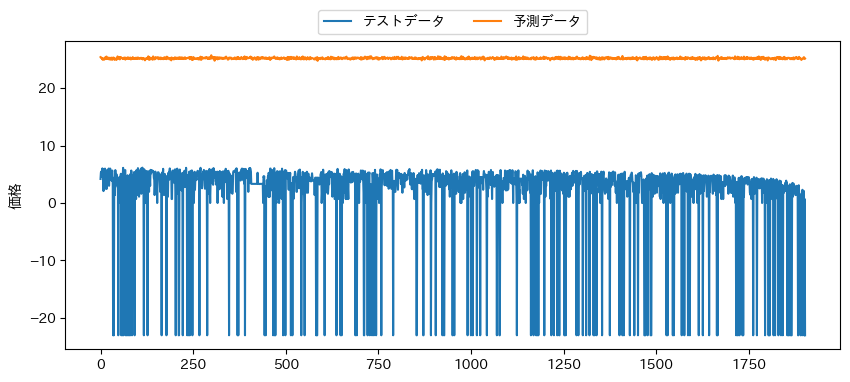

In [63]:
# テストデータに対する推定結果のプロット
import japanize_matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(10, 4))
plt.plot(np_log(y_test.values))
plt.plot(np.exp(predictions))
# plt.xlabel('')
plt.ylabel('価格')
plt.legend(['テストデータ', '予測データ'], loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.show()

In [ ]:
# 回帰の結果を取得
regression_results = predictions.squeeze().tolist()
print(regression_results)